In [5]:
!pip install transformers datasets -q

In [6]:
!pip install transformers -q

In [20]:
from transformers import AutoImageProcessor, Dinov2Model

model_ckpt = "facebook/dinov2-giant"
processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = Dinov2Model.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

In [21]:
model

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-39): 40 x Dinov2Layer(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1536, out_features=1536, bias=True)
            (key): Linear(in_features=1536, out_features=1536, bias=True)
            (value): Linear(in_features=1536, out_features=1536, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1536, out_features=1536, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_

In [22]:
processor

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

In [23]:
import torch
model = model.to('cuda')

In [24]:
from datasets import load_dataset

dataset = load_dataset("beans")

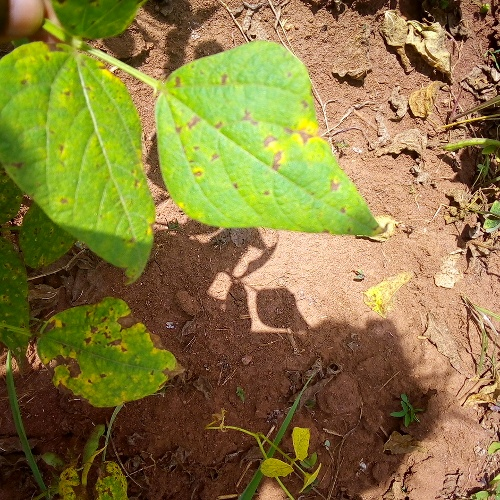

In [25]:
# Check a sample image.
dataset["train"][0]["image"]

In [26]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

In [27]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [28]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [29]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * processor.crop_size["height"])),
        T.CenterCrop(processor.crop_size["height"]),
        T.ToTensor(),
        T.Normalize(mean=processor.image_mean, std=processor.image_std),
    ]
)

In [31]:
import torch


def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images_ = batch["image"]
        image_batch_transformed = processor(images=images_, return_tensors="pt").to(device)
        # new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            output = model(**image_batch_transformed)
            embeddings = output.last_hidden_state[:, 0].cpu()
            print(embeddings.shape)
        return {"embeddings": embeddings}

    return pp


# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([24, 1536])
torch.Size([24, 1536])
torch.Size([24, 1536])
torch.Size([24, 1536])
torch.Size([4, 1536])


In [32]:
from tqdm.auto import tqdm


candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [34]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    new_batch = processor(images=image, return_tensors="pt").to(device)
    #new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

In [42]:
test_idx = np.random.choice(len(dataset["test"]))
test_sample = dataset["test"][test_idx]["image"]
test_label = dataset["test"][test_idx]["labels"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 2
Top 5 candidate labels: [2, 2, 1, 2, 2]


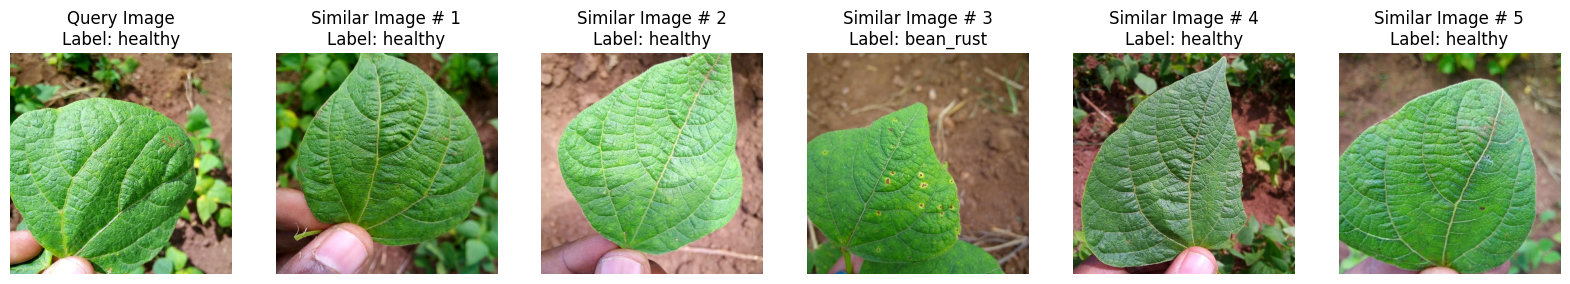

In [43]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, int(i + 1))
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

In [53]:
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/4f/d7/3303f11188122f66c940056f162d030992e7fbc9c702869bab163e85156b/matplotlib-3.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/d8/23/8d968922459b1c8a2c6ffca28fac00324b06b3a0633be2a39b0b1c3f84ab/contourpy-1.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/07/fb/c507a09ab93642224417c31a3acd2806bfa53f4d723cf5d6cbdf62f2f337/fonttools-4.42.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 5.2 MB/s eta 0:00:00
  Obtaining dependency information for kiwisolver>=1.0.1 from https://files.pythonhosted.org/packages/17/ba/17a706b232308e65f57deeccae503c268292e6a091313f6ce833a23093